# Fitting Rotation Maps with Elevated Emission Surfaces

This Notebook deals with disks where the vertical structure can clearly be resolved. This is highly likely now that ALMA observations are routinely achieving angular resolutions of a few hundreds of milliarcseconds and bright $^{12}{\rm CO}$ emission is typically observed.

## HD 163296 - A Geometrically Thick Disk

The vertical extent of a disk can be seen in the rotation map as the lobes of the dipole rotation pattern bend away from the disk major axis. This is very clear for the case of HD 163296. We can use the `plot_maxima` function which will find the line of maximum and minimum velocities along the red-shifted and blue-shifted major axes, respectively.

In [1]:
%matplotlib inline
from eddy.fit_cube import rotationmap

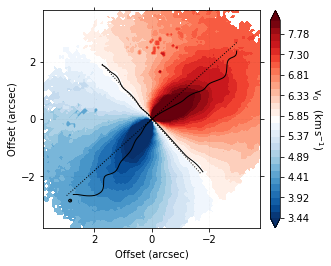

In [2]:
# Load up the data.

cube = rotationmap(path='../../cubes/HD163296_CO_v0.fits',
                   uncertainty='../../cubes/HD163296_CO_dv0.fits',
                   downsample=5, clip=3.75)

# Plot the line of nodes.

cube.plot_maxima(inc=49.7, PA=312.0, r_max=4.0, smooth=0.3)

In the above figure, the dotted lines show the major and minor axes of the disk based on the `inc` and `PA` values provided. The solid lines show the line of extreme velocities, showing that the emission surface is distinctly elevated. 

## Parameterising the Emission Height

We can go beyond the geometrically thin disk approximation and use a more realistic 3D structure. Here we assume an azimuthually symmetric emission surface parameterized by

$$z(r) = z_0 \cdot (r \, / \, 1^{\prime\prime})^{\psi}$$

With this we can recover the geometrically thin limit when $z_0 = 0$ and the conical surface discussed in [Rosenfeld et al. (2013)](https://ui.adsabs.harvard.edu/#abs/2013ApJ...774...16R). We have also included the possibility to have a more complex surface,

$$z(r) = z_0 \cdot (r \, / \, 1^{\prime\prime})^{\psi} + z_1 \cdot (r \, / \, 1^{\prime\prime})^{\varphi}$$

which allows for the decreasing emission surface in the outer disk. However testing has shown for convergence you need very high spatial resolution for a reasonable convergence.

The inclusion of a non-zero height will have two affects. Firstly, it will alter the deprojection which will have most significant difference along the semi-minor axis. Secondly, we have to correct $v_{\rm kep}$ for a) the additional distance to the star from an elevated location (difference in a radial polar coordinate and a radial cylindrical coordinate), and b) the projected gravitational force, resulting in,

$$v_{\rm kep} = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3\,/\,2}}},$$

where $r$ is the cylindrical (or midplane) radius. This means we need to introduce two more parameters: `z0` and `psi` to define the emission surface. The fitting works exactly as with the geometrically thin case, however some care has to be taken with the outer radius of the mask.

### Choice of Mask

At first it may seem strange to have `r_max = 3.25` when the emission clearly extends out past $4^{\prime\prime}$. We have chosen this size as we want to limit the confusion from the far side of the disk. This is the region in the North-East of the image, as demonstrated in the first figure of the [`fit_annulus` tutorial](fitannulus_2.ipynb).

Assuming:
	p0 = [${\rm x0}$, ${\rm y0}$, ${\rm PA}$, ${\rm mstar}$, ${\rm vlsr}$, ${\rm z0}$, ${\rm psi}$, ${\rm z1}$, ${\rm phi}$].


100%|██████████| 2200/2200 [10:51<00:00,  3.38it/s]


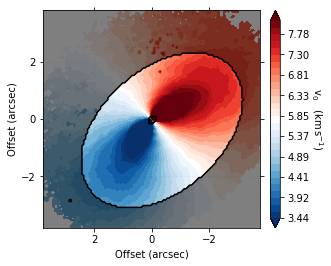

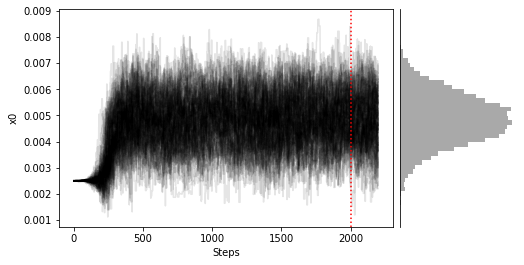

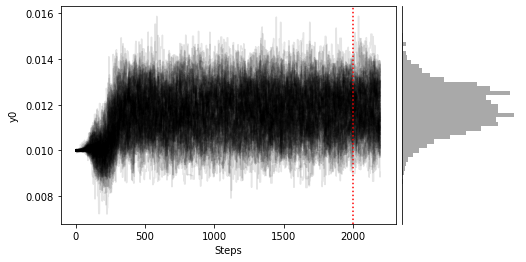

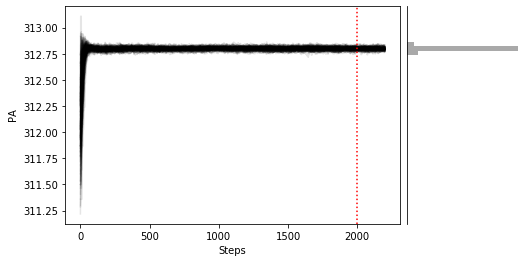

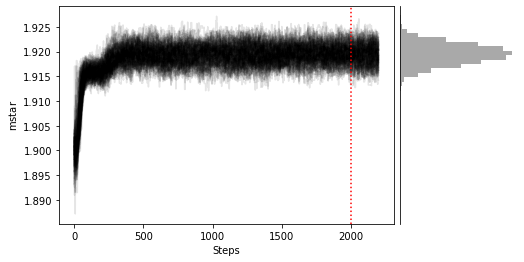

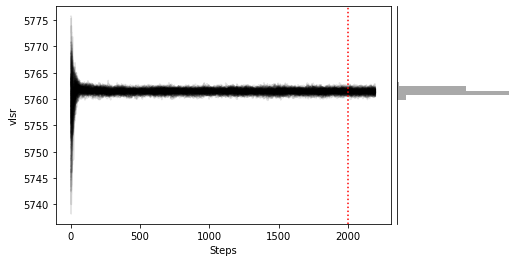

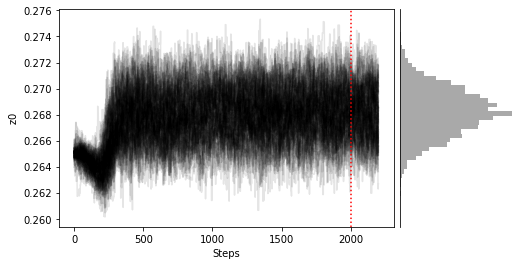

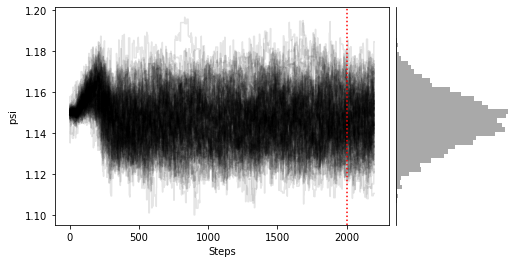

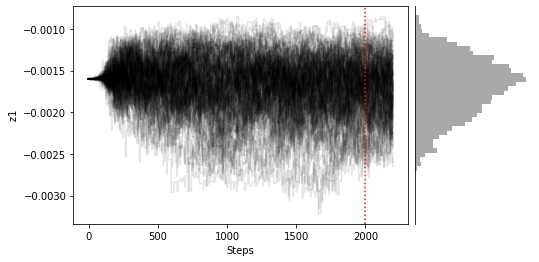

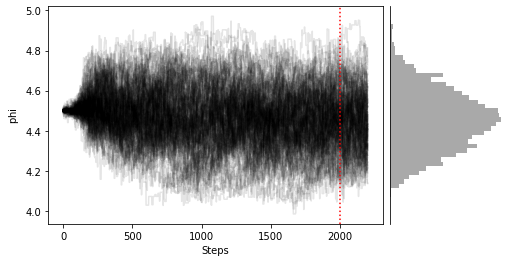

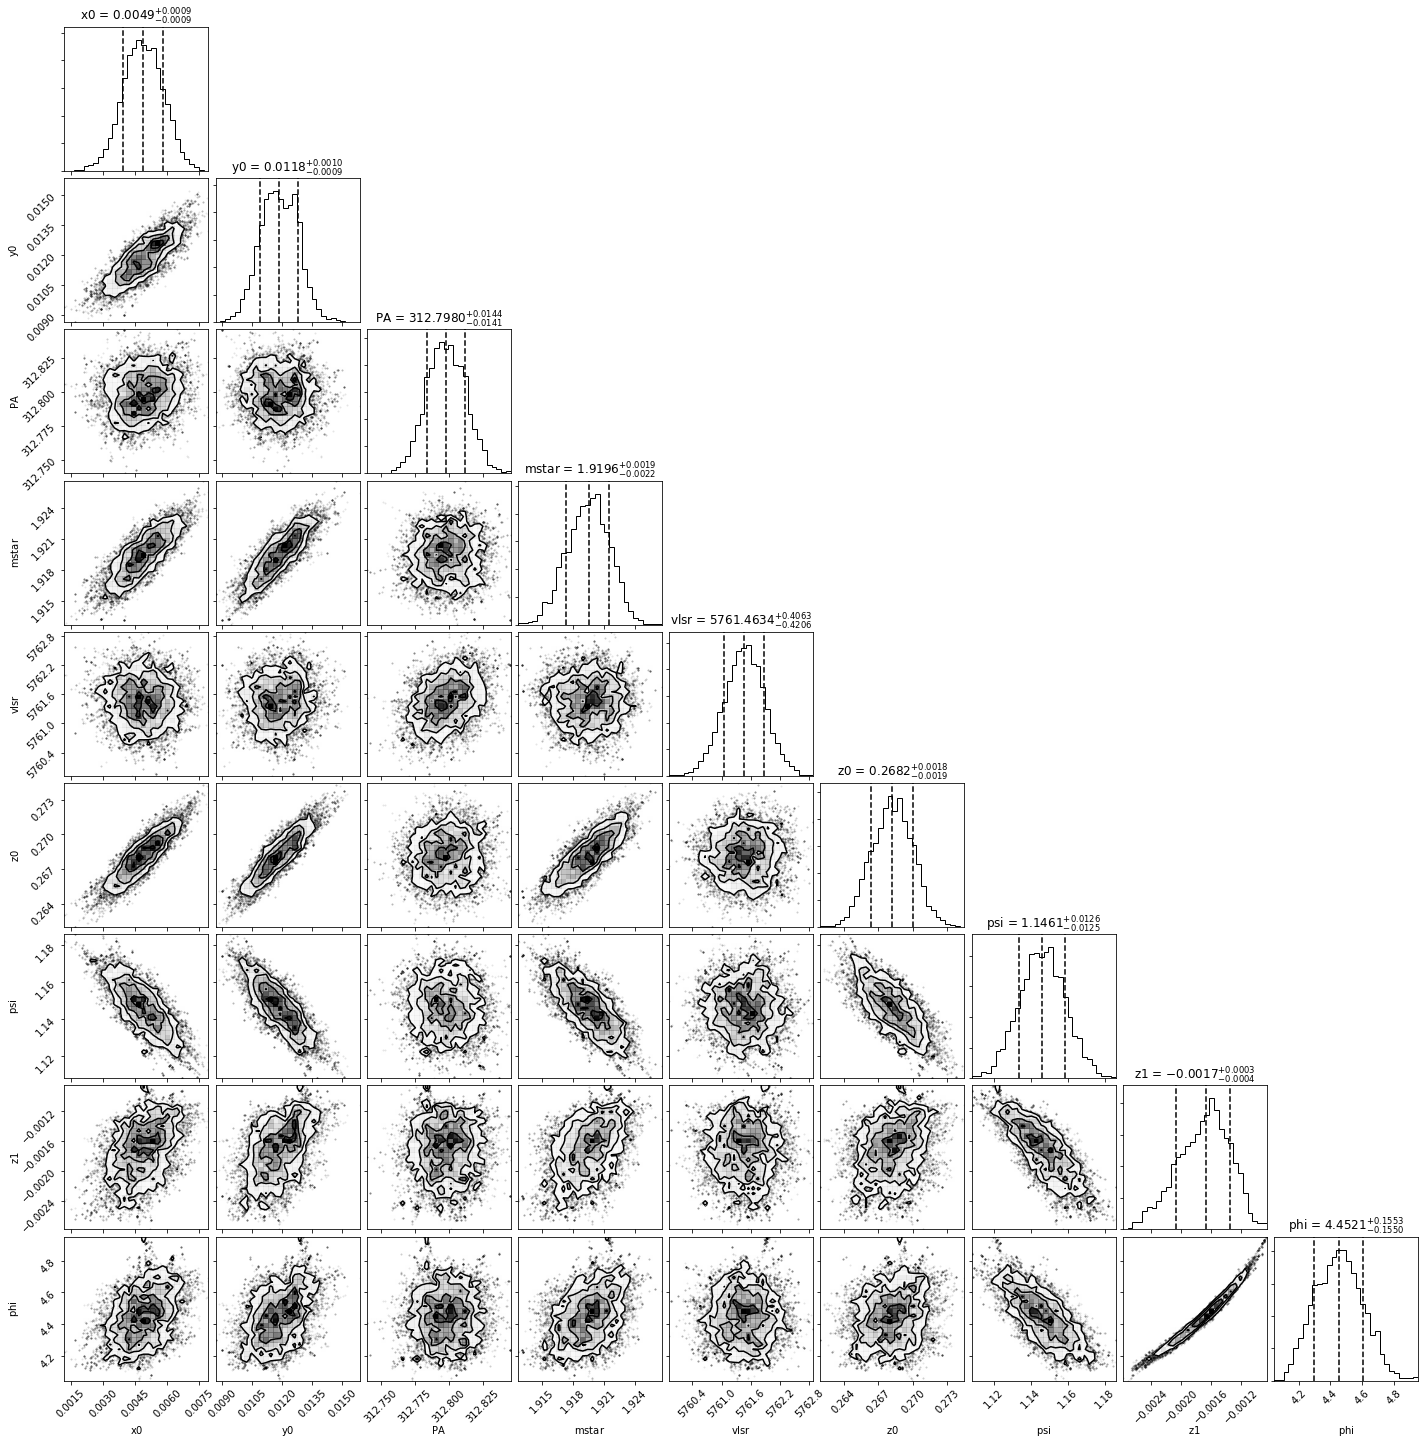

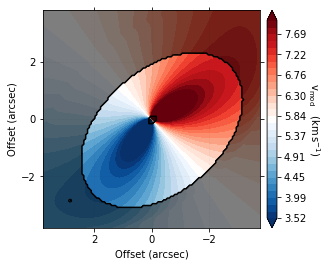

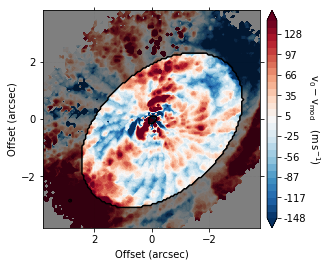

In [3]:
params = {}

# Start with the positions of the free variables in p0.
# Note that as we have non-zero z values we must keep Mstar
# a free parameter to account for this change.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4
params['z0'] = 5
params['psi'] = 6
params['z1'] = 7
params['phi'] = 8

p0 = [2.5e-3, 10e-3, 312., 1.9, 5.76e3, 0.265, 1.15, -1.6e-3, 4.5]

# Fix the other parameters.

params['inc'] = 49.7    # degrees
params['dist'] = 101.0  # parsec
params['beam'] = False  # should we convolve the model? **MUST BE A BOOLEAN**

# Dictate where the mask is.

r_min = 2.0 * cube.bmaj
r_max = 3.25

# Run the MCMC.

from multiprocessing import Pool

with Pool() as pool:
    samples = cube.fit_map(p0=p0, params=params, r_min=r_min, r_max=r_max,
                           nwalkers=128, nburnin=2000, nsteps=200, pool=pool,
                           optimize=False)

### Residuals

In the residual map you can see a lot of structure. The most prominent are the positive and negative residuals along the major axis which are due to the pressure support of the gas disk resulting in slower rotation at larger radii. This was another reason why the `r_max` value was set smaller than one would typically expect.

There's also spoke-like features around the disk, due to the channelization of the data. Although the model is able to create a continuous rotation pattern, the accuracy of the `v0` maps is limited by the velocity resolution of the data.

Finally, there are some arc like structures in the disk. There's one centered at $(-0.5^{\prime\prime},\,1.5^{\prime\prime})$, roughly at the location of the velocity kink reported by [Pinte et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..13P/abstract). If this is what such a kink looks like in residuals, perhaps there are many more planets in the disk...

## Plotting the Emission Surface

Now that we have constrained the emission surface (on the assumption that out model is a reasonable replication of the true source structure), we can overplot the emission surface to check what that looks like.

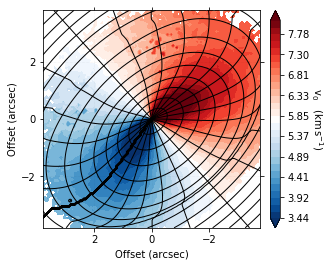

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# First plot the background data.

fig = cube.plot_data(return_fig=True)
ax = fig.axes[0]

# Take the median values of the PDFs for the emission height and plot.

z0, psi, z1, phi = np.median(samples, axis=0)[-4:]
cube.plot_surface(ax=ax, inc=49.7, PA=312.0, z0=z0, psi=psi, z1=z1, phi=phi)